In [1]:
from functions import *
import pandas as pd
import seaborn as sns
import statistics
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, median_absolute_error, mean_squared_error
%matplotlib inline
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import numpy as np

SAMPLE = 5000 # Training sample 5000, 20.000
GRANULARITY = 15000 # Only work with the last X rows of data sets 15.000, 220.000
REMOVE_OUTLIERS = False # False, or Number for whisker, 3 = only remove extreme outliers
ONLY_TRANSPARENT = False # False, or True, filter for only TSP blocks

blocks_HDD = pd.read_csv("./raw_data/HDD/eval_all_blocks.csv", names=["BLOCK", "BLOCK_NS"])
blocks_SSD = pd.read_csv("./raw_data/SSD/eval_all_blocks.csv", names=["BLOCK", "BLOCK_NS"])

blocks_info = pd.read_csv("./data/enhanced_block.csv", names=["BLOCK", "SIZE", "VERSION", "numberTX", "numberVin", "numberVout", "numberJoinSplit", "numbervShieldedSpend", "numbervShieldedOutput"])

data_inputs_HDD = pd.read_csv("./raw_data/HDD/data_ecdsa.csv", names=["BLOCK", "NS"])
data_spends_HDD = pd.read_csv("./raw_data/HDD/data_shieldedSpend.csv", names=["BLOCK", "NS"])
data_outputs_HDD = pd.read_csv("./raw_data/HDD/data_shieldedOutput.csv", names=["BLOCK", "NS"])
data_joinSplits_HDD = pd.read_csv("./raw_data/HDD/data_joinsplit.csv", names=["BLOCK", "NS"])

data_inputs_SSD = pd.read_csv("./raw_data/SSD/data_ecdsa.csv", names=["BLOCK", "NS"])
data_spends_SSD = pd.read_csv("./raw_data/SSD/data_shieldedSpend.csv", names=["BLOCK", "NS"])
data_outputs_SSD = pd.read_csv("./raw_data/SSD/data_shieldedOutput.csv", names=["BLOCK", "NS"])
data_joinSplits_SSD = pd.read_csv("./raw_data/SSD/data_joinsplit.csv", names=["BLOCK", "NS"])

# Clean data
onlyContainingTransparent = blocks_info.loc[(blocks_info['numberJoinSplit'] == 0) & (blocks_info['numbervShieldedSpend'] == 0) & (blocks_info['numbervShieldedOutput'] == 0)]

# Remove extreme outliers
if REMOVE_OUTLIERS:
    old_count_hdd = blocks_HDD['BLOCK'].count()
    old_count_ssd = blocks_SSD['BLOCK'].count()
    blocks_HDD = subset_by_iqr(blocks_HDD, 'BLOCK_NS', whisker_width=REMOVE_OUTLIERS) 
    blocks_SSD = subset_by_iqr(blocks_SSD, 'BLOCK_NS', whisker_width=REMOVE_OUTLIERS)
    print('Outliers: {} removed for HDD and {} removed for SSD'.format(old_count_hdd - blocks_HDD['BLOCK'].count(), old_count_ssd - blocks_SSD['BLOCK'].count()))

# Make sure no wrong tx was recorded 
data_spends_HDD = data_spends_HDD[~data_spends_HDD['BLOCK'].isin(onlyContainingTransparent['BLOCK'])]
data_outputs_HDD = data_outputs_HDD[~data_outputs_HDD['BLOCK'].isin(onlyContainingTransparent['BLOCK'])]
data_joinSplit_HDD = data_joinSplits_HDD[~data_joinSplits_HDD['BLOCK'].isin(onlyContainingTransparent['BLOCK'])]
data_spends_SSD = data_spends_SSD[~data_spends_SSD['BLOCK'].isin(onlyContainingTransparent['BLOCK'])]
data_outputs_SSD = data_outputs_SSD[~data_outputs_SSD['BLOCK'].isin(onlyContainingTransparent['BLOCK'])]
data_joinSplit_SSD = data_joinSplits_SSD[~data_joinSplits_SSD['BLOCK'].isin(onlyContainingTransparent['BLOCK'])]

# Merge Data
blocks = blocks_SSD.merge(blocks_HDD, how='inner', left_on="BLOCK", right_on="BLOCK", suffixes=('_SSD', '_HDD'))
blocks = blocks.merge(blocks_info, how='inner', left_on="BLOCK", right_on="BLOCK")
if ONLY_TRANSPARENT:
    blocks = blocks[blocks['BLOCK'].isin(onlyContainingTransparent['BLOCK'])]

if GRANULARITY: 
    blocks = blocks.tail(GRANULARITY)

print('Blocks ' + blocks.iloc[0]['BLOCK'] + ' till ... ' + blocks.iloc[-1]['BLOCK'])

Blocks 0000000000b3f611c39a11469981884bd0b34c9954c51c80a6c5d667729a88ec till ... 00000000009e4f8f692d035202d57fcf3d8e62c1dd9a5802daa4f82794436b51


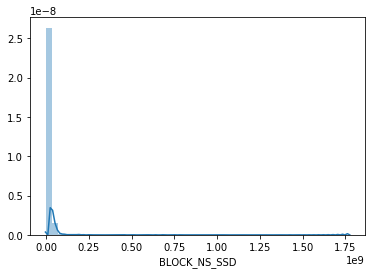

In [2]:
sns.distplot(blocks['BLOCK_NS_SSD'])

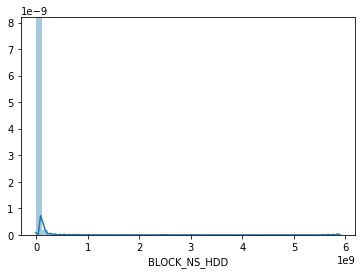

In [3]:
sns.distplot(blocks['BLOCK_NS_HDD'])

In [4]:
def calculate_error(real, predicted):
    print('MEAN aboslute error: ', mean_absolute_error(real, predicted))
    print('MEAN rleative (%) error: ', mean_absolute_error_percent(real, predicted))
    print('Median aboslute error: ', median_absolute_error(real, predicted))
    print('Median rleative (%) error: ', median_absolute_error_percent(real, predicted))
    print('Mean Squared error:', mean_squared_error(real, predicted))
    print('R2: ', r2_score(real, predicted))    

In [5]:
def model(meNS, meNS_Byte, estimates, postfix):
    estimates['KB_' + postfix] = meNS_Byte * estimates["SIZE"]
    calculate_error(estimates["BLOCK_NS_" + postfix], estimates['KB_' + postfix])

In [6]:
# k * b
estimates = blocks.copy(deep=True)

print('HDD KB...')
meNS = estimates["BLOCK_NS_HDD"].tail(SAMPLE).median()
meNS_Byte = meNS / estimates["SIZE"].tail(SAMPLE).median()
model(meNS, meNS_Byte, estimates, 'HDD')

print('SSD KB...')
meNS = estimates["BLOCK_NS_SSD"].tail(SAMPLE).median()
meNS_Byte = meNS / estimates["SIZE"].tail(SAMPLE).median()
model(meNS, meNS_Byte, estimates, 'SSD')

HDD KB...
MEAN aboslute error:  27552713.84450135
MEAN rleative (%) error:  78.96266535422728
Median aboslute error:  7011620.167602722
Median rleative (%) error:  65.26504743679767
Mean Squared error: 2.428282780823927e+16
R2:  0.07519558831000561
SSD KB...
MEAN aboslute error:  9778775.974780383
MEAN rleative (%) error:  70.75646775986954
Median aboslute error:  2263638.700635531
Median rleative (%) error:  55.672366509436756
Mean Squared error: 1801211053515258.5
R2:  0.18116575188698214


In [7]:
def model_improved(kI, kS, kO, kJ, k, estimates, postfix):
    estimates['KV_' + postfix] = estimates['numbervShieldedSpend'] * kS + estimates['numbervShieldedOutput'] * kO + estimates['numberVin'] * kI + estimates['numberJoinSplit'] * kJ + k
    calculate_error(estimates["BLOCK_NS_" + postfix], estimates['KV_' + postfix])

In [8]:
# k + vi * ki + vs * ks
kI = group_block(data_inputs_HDD)['NS_median'].tail(SAMPLE).median()
kS = group_block(data_spends_HDD)['NS_median'].tail(SAMPLE).median()
kO = group_block(data_outputs_HDD)['NS_median'].tail(SAMPLE).median()
kJ = group_block(data_joinSplits_HDD)['NS_median'].tail(SAMPLE).median()

k = estimates["BLOCK_NS_HDD"].tail(SAMPLE).median() - (estimates['numberJoinSplit'].tail(SAMPLE).median() * kJ + estimates['numbervShieldedSpend'].tail(SAMPLE).median() * kS + estimates['numbervShieldedOutput'].tail(SAMPLE).median() * kO + estimates['numberVin'].tail(SAMPLE).median() * kI)

print('HDD KV...')
model_improved(kI, kS, kO, kJ, k, estimates, 'HDD')

kI = group_block(data_inputs_SSD)['NS_median'].tail(SAMPLE).median()
kS = group_block(data_spends_SSD)['NS_median'].tail(SAMPLE).median()
kO = group_block(data_outputs_SSD)['NS_median'].tail(SAMPLE).median()
kJ = group_block(data_joinSplits_SSD)['NS_median'].tail(SAMPLE).median()

k = estimates["BLOCK_NS_SSD"].tail(SAMPLE).median() - (estimates['numberJoinSplit'].tail(SAMPLE).median() * kJ + estimates['numbervShieldedSpend'].tail(SAMPLE).median() * kS + estimates['numbervShieldedOutput'].tail(SAMPLE).median() * kO + estimates['numberVin'].tail(SAMPLE).median() * kI)

print('SSD KV...')
model_improved(kI, kS, kO, kJ, k, estimates, 'SSD')

HDD KV...
MEAN aboslute error:  22951267.9626
MEAN rleative (%) error:  65.77549136589528
Median aboslute error:  8539325.0
Median rleative (%) error:  79.4851172598216
Mean Squared error: 2.4458958066913876e+16
R2:  0.0684877188007097
SSD KV...
MEAN aboslute error:  4844709.1476
MEAN rleative (%) error:  35.054950383583474
Median aboslute error:  857250.5
Median rleative (%) error:  21.08338402811313
Mean Squared error: 844747774725234.2
R2:  0.6159759248577015


<Figure size 432x288 with 0 Axes>

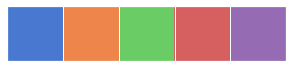

In [9]:
# Prepare plots
color = "muted"
sns.set(style="darkgrid", palette=color, color_codes=True)
sns.despine(left=True)
plt.rcParams['figure.figsize'] = [10/2.54, 8/2.54]
color = sns.color_palette(color, 5)
sns.palplot(sns.color_palette(color, 5))
color_primary = color[0]
color_kb = color[2]
color_r2 = color[3]
color_kv = color[1]

In [10]:
# Now we use linear regression to better predict the coefficients 
estimates_reg = blocks.copy(deep=True)
test_size = SAMPLE / estimates_reg['BLOCK'].count()
X_train, X_test = train_test_split(estimates_reg, train_size=test_size, random_state=42)
print('Test Blocks: ' + str(X_test['BLOCK'].count()))
print('Train Blocks: ' + str(X_train['BLOCK'].count()))

regr_kb_hdd = LinearRegression().fit(X_train[["SIZE"]], X_train['BLOCK_NS_HDD'])
X_test['KB_HDD'] = regr_kb_hdd.predict(X_test[["SIZE"]])
print('LR KB_HDD...')
print('Coefficients: \n', regr_kb_hdd.coef_)
print('Intercept: \n', regr_kb_hdd.intercept_)
calculate_error(X_test['BLOCK_NS_HDD'], X_test['KB_HDD'])

regr_kb_ssd = LinearRegression().fit(X_train[["SIZE"]], X_train['BLOCK_NS_SSD'])
X_test['KB_SSD'] = regr_kb_ssd.predict(X_test[["SIZE"]])
print('LR KB_SSD...')
print('Coefficients: \n', regr_kb_ssd.coef_)
print('Intercept: \n', regr_kb_ssd.intercept_)
calculate_error(X_test['BLOCK_NS_SSD'], X_test['KB_SSD'])

regr_kv_hdd = LinearRegression().fit(X_train[["numberVin", "numberJoinSplit", "numbervShieldedSpend", "numbervShieldedOutput"]], X_train['BLOCK_NS_HDD'])
X_test['KV_HDD'] = regr_kv_hdd.predict(X_test[["numberVin", "numberJoinSplit", "numbervShieldedSpend", "numbervShieldedOutput"]])
print('LR KV_HDD...')
print('Coefficients: \n', regr_kv_hdd.coef_)
print('Intercept: \n', regr_kv_hdd.intercept_)
calculate_error(X_test['BLOCK_NS_HDD'], X_test['KV_HDD'])

regr_kv_ssd = LinearRegression().fit(X_train[["numberVin", "numberJoinSplit", "numbervShieldedSpend", "numbervShieldedOutput"]], X_train['BLOCK_NS_SSD'])
X_test['KV_SSD'] = regr_kv_ssd.predict(X_test[["numberVin", "numberJoinSplit", "numbervShieldedSpend", "numbervShieldedOutput"]])
print('LR KV_SSD...')
print('Coefficients: \n', regr_kv_ssd.coef_)
print('Intercept: \n', regr_kv_ssd.intercept_)
calculate_error(X_test['BLOCK_NS_SSD'], X_test['KV_SSD'])

estimates_reg = X_test

Test Blocks: 10000
Train Blocks: 5000
LR KB_HDD...
Coefficients: 
 [4345.45401353]
Intercept: 
 8784760.27829269
MEAN aboslute error:  31195802.76923689
MEAN rleative (%) error:  91.0796991027546
Median aboslute error:  15515904.872276403
Median rleative (%) error:  144.26891004780543
Mean Squared error: 2.1806452908653536e+16
R2:  0.09099044724326855
LR KB_SSD...
Coefficients: 
 [1717.37766995]
Intercept: 
 3584715.478678396
MEAN aboslute error:  10594982.491268016
MEAN rleative (%) error:  78.33573672636803
Median aboslute error:  4824417.197199767
Median rleative (%) error:  118.68184986961296
Mean Squared error: 1417708149283514.0
R2:  0.25197443361807337
LR KV_HDD...
Coefficients: 
 [  246312.53207514 39760495.90448157  9862146.43768432 10999119.281232  ]
Intercept: 
 13209041.701389644
MEAN aboslute error:  22051200.67285564
MEAN rleative (%) error:  64.38099179543188
Median aboslute error:  11673708.233464785
Median rleative (%) error:  108.54366386760192
Mean Squared error: 2.0

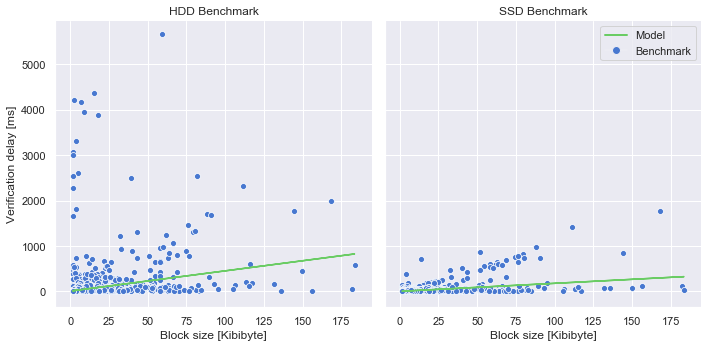

In [11]:
# Compare KB with NS and size
estimates_KB = estimates_reg.copy(deep=True)
estimates_KB = estimates_KB.rename(columns={'BLOCK_NS_HDD': 'HDD', 'BLOCK_NS_SSD': 'SSD'})

# melt data
gridplotdata = pd.melt(estimates_KB, id_vars=['KB_HDD', 'KB_SSD', 'BLOCK','SIZE'], value_vars=['HDD', 'SSD'])

gridplotdata["SIZE"] = gridplotdata["SIZE"] / 1024 # Convert to Kibibyte
gridplotdata["value"] = gridplotdata["value"] / 1000000 # Convert to ms
gridplotdata["KB_HDD"] = gridplotdata["KB_HDD"] / 1000000 # Convert to ms
gridplotdata["KB_SSD"] = gridplotdata["KB_SSD"] / 1000000 # Convert to ms

grid = sns.FacetGrid(gridplotdata, col="variable", height=5, legend_out=False)
grid = grid.map(sns.scatterplot, "SIZE", "value", color=color_primary, edgecolors='w')
#grid.set(ylim=(None, 3000))
#grid.set(xlim=(None, 130))

ax1, ax2 = grid.axes[0]
ax1.plot(gridplotdata["SIZE"], gridplotdata["KB_HDD"], color=color_kb)
ax2.plot(gridplotdata["SIZE"], gridplotdata["KB_SSD"], color=color_kb)

from matplotlib.lines import Line2D
b_patch = Line2D([0], [0], color=color_kb, lw=2, label='Model')
g_patch = Line2D([0], [0], marker='o', color='#EDEDF4', label='Benchmark', markerfacecolor=color_primary, markersize=8)
plt.legend(handles=[b_patch, g_patch])

grid.set_xlabels('Block size [Kibibyte]')
grid.set_ylabels('Verification delay [ms]')
grid.set_titles('{col_name} Benchmark')

grid.fig.savefig("KB.pdf", bbox_inches='tight')

In [12]:
# Compare all models based on block size
d1 = pd.melt(estimates_reg.rename(columns={'BLOCK_NS_HDD': 'HDD', 'BLOCK_NS_SSD': 'SSD'}), id_vars=['BLOCK','SIZE', 'KV_SSD', 'KV_HDD', 'KB_SSD', 'KB_HDD'], value_vars=['HDD', 'SSD'], var_name='Type', value_name='Benchmark')

d1['KV'] = d1['KV_HDD']
d1['KB'] = d1['KB_HDD']

d1.loc[d1['Type'] == 'SSD', 'KV'] = d1['KV_SSD']
d1.loc[d1['Type'] == 'SSD', 'KB'] = d1['KB_SSD']

d1 = pd.melt(d1.rename(columns={'KV': 'Improved Model', 'KB': 'Naive Model'}), id_vars=['SIZE', 'Type'], value_vars=['Benchmark', 'Improved Model', 'Naive Model'], var_name='Model', value_name='NS')

d1["NS"] = d1["NS"] / 1000000 # Convert to mss
d1["SIZE"] = d1["SIZE"] / 1024 # Convert to Kibibyte

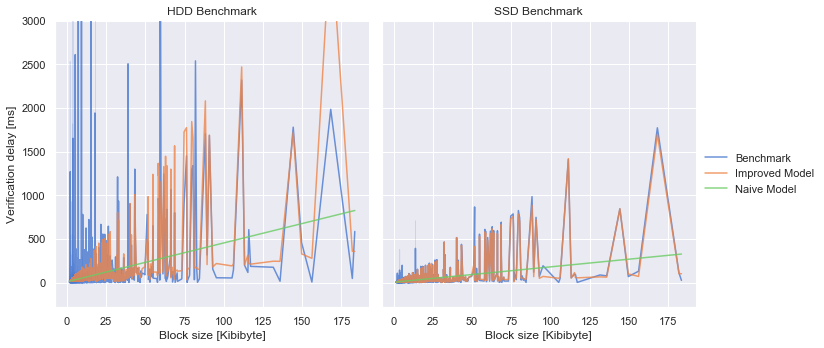

In [13]:
grid = sns.FacetGrid(d1, col="Type", height=5, hue="Model", palette=[color_primary, color_kv, color_kb])
grid = grid.map(sns.lineplot, "SIZE", "NS", alpha=0.8)
grid.set(ylim=(None, 3000))
grid.add_legend(title='')

grid.set_xlabels('Block size [Kibibyte]')
grid.set_ylabels('Verification delay [ms]')
grid.set_titles('{col_name} Benchmark')
grid.fig.savefig("KV_KB_Size.pdf", bbox_inches='tight')

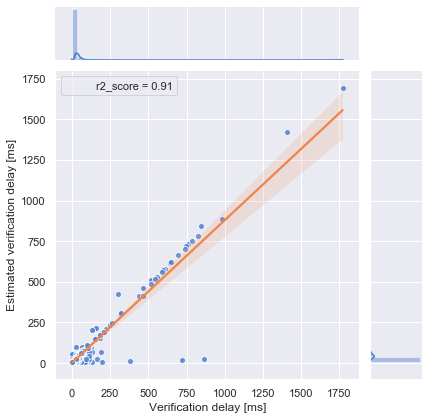

In [14]:
# Compare models with real values
gridplotdata = estimates_reg.copy(deep=True)

gridplotdata["BLOCK_NS_SSD"] = gridplotdata["BLOCK_NS_SSD"] / 1000000 # 1000000 # Convert to ms
gridplotdata["KV_SSD"] = gridplotdata["KV_SSD"] / 1000000 # 1000000 # Convert to ms
gridplotdata["KB_SSD"] = gridplotdata["KB_SSD"] / 1000000 # 1000000 # Convert to ms

grid = sns.jointplot(data=gridplotdata, x='BLOCK_NS_SSD', y='KV_SSD', kind="reg", stat_func=r2_score, marginal_kws={'color': color_primary}, joint_kws={'scatter_kws':{'edgecolor':'white'}, 'line_kws':{'color': color_kv}})
#grid.ax_joint.set(ylim=(0, 100))
#grid.ax_joint.set(xlim=(0, 100))

grid.ax_joint.set_xlabel('Verification delay [ms]')
grid.ax_joint.set_ylabel('Estimated verification delay [ms]')

grid.fig.savefig("KV_R2.pdf", bbox_inches='tight')


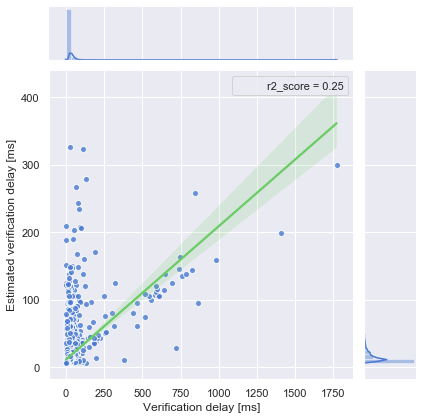

In [15]:
grid = sns.jointplot(data=gridplotdata, x='BLOCK_NS_SSD', y='KB_SSD', kind="reg", stat_func=r2_score, marginal_kws={'color': color_primary}, joint_kws={'scatter_kws':{'edgecolor':'white'} ,'line_kws':{'color': color_kb}})

grid.ax_joint.set_xlabel('Verification delay [ms]')
grid.ax_joint.set_ylabel('Estimated verification delay [ms]')

grid.fig.savefig("KB_R2.pdf", bbox_inches='tight')

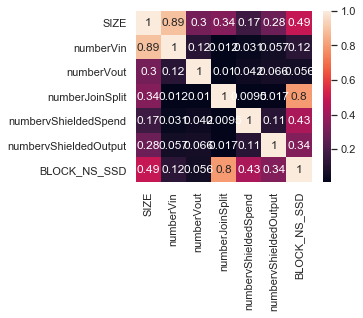

In [16]:
#Correlation
corrMatrix = blocks[["SIZE", "numberVin", "numberVout", "numberJoinSplit", "numbervShieldedSpend", "numbervShieldedOutput", "BLOCK_NS_SSD"]].corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [17]:
abs(corrMatrix['BLOCK_NS_SSD'])

SIZE                     0.487774
numberVin                0.124236
numberVout               0.056160
numberJoinSplit          0.795232
numbervShieldedSpend     0.430726
numbervShieldedOutput    0.335796
BLOCK_NS_SSD             1.000000
Name: BLOCK_NS_SSD, dtype: float64